# Resuspension rate classification

Based on tidal speeds from Jacqui-Lee

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import datetime
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import pickle
import scipy.io

%matplotlib notebook

###### Parameters:

In [3]:
imin, imax = 1100, 2050
jmin, jmax = 160, 800

###### Load files:

In [5]:
mesh       = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
mesh_lon   = np.array(mesh.variables['nav_lon'])
mesh_lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])

bathy_masked = np.ma.masked_where((mesh_bathy > 0.1), mesh_bathy)

Load tidal speed array from Jacqui-Lee:

In [6]:
mat         = scipy.io.loadmat('/ocean/brogalla/GEOTRACES/data/mean_tide_speed.mat')
tidal_speed = mat['mean_speed']

ts_mesh     = nc.Dataset('/ocean/brogalla/GEOTRACES/data/hsquare.nc')
ts_lons     = np.array(ts_mesh.variables['nav_lon'])
ts_lats     = np.array(ts_mesh.variables['nav_lat'])

##### Functions:

Interpolate ANHA4 to ANHA12 grid:

In [13]:
def interp_np(nav_lon, nav_lat, var_in, lon_ANHA12, lat_ANHA12):
    ''' Interpolate Mn model output from Marco to ANHA12 grid.
        The function is based on the bilinear interpolation in scipy, griddata 
        =======================================================================
            nav_lon, nav_lat        : Mn model lons/lats
            lon_ANHA12, lat_ANHA12  : ANHA12 defined lons/lats
            var_in                  : 2-D Mn model variable
    '''
    from scipy.interpolate import griddata

    LatLonPair = (nav_lon.flatten(), nav_lat.flatten())
    var_out = griddata(LatLonPair, var_in.flatten(), (lon_ANHA12, lat_ANHA12), method='linear')
    # Take nearest neighbour interpolation to fill nans
    var_fill = griddata(LatLonPair, var_in.flatten(), (lon_ANHA12, lat_ANHA12), method='nearest')
    var_out[np.isnan(var_out)] = var_fill[np.isnan(var_out)]
    return var_out

##### Calculations:

In [29]:
tidal_stress     = tidal_speed**2 
log_tidal_stress = np.log10(tidal_stress)

In [30]:
tidal_speed_ANHA12 = interp_np(ts_lons, ts_lats, tidal_speed, mesh_lon, mesh_lat)

In [31]:
tidal_speed_ANHA12[np.isnan(tidal_speed_ANHA12)] = 0

In [32]:
tidal_speed_ANHA12[tidal_speed_ANHA12 < 0.1] = 0

In [33]:
tidal_speed_ANHA12[mesh_bathy < 0.1] = 0 # zero where on land

In [34]:
erosion_rate = 0.3e-6*tidal_speed_ANHA12**2

In [35]:
log_erosion_rate = np.log10(erosion_rate)

/home/brogalla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


##### Figures:

<IPython.core.display.Javascript object>


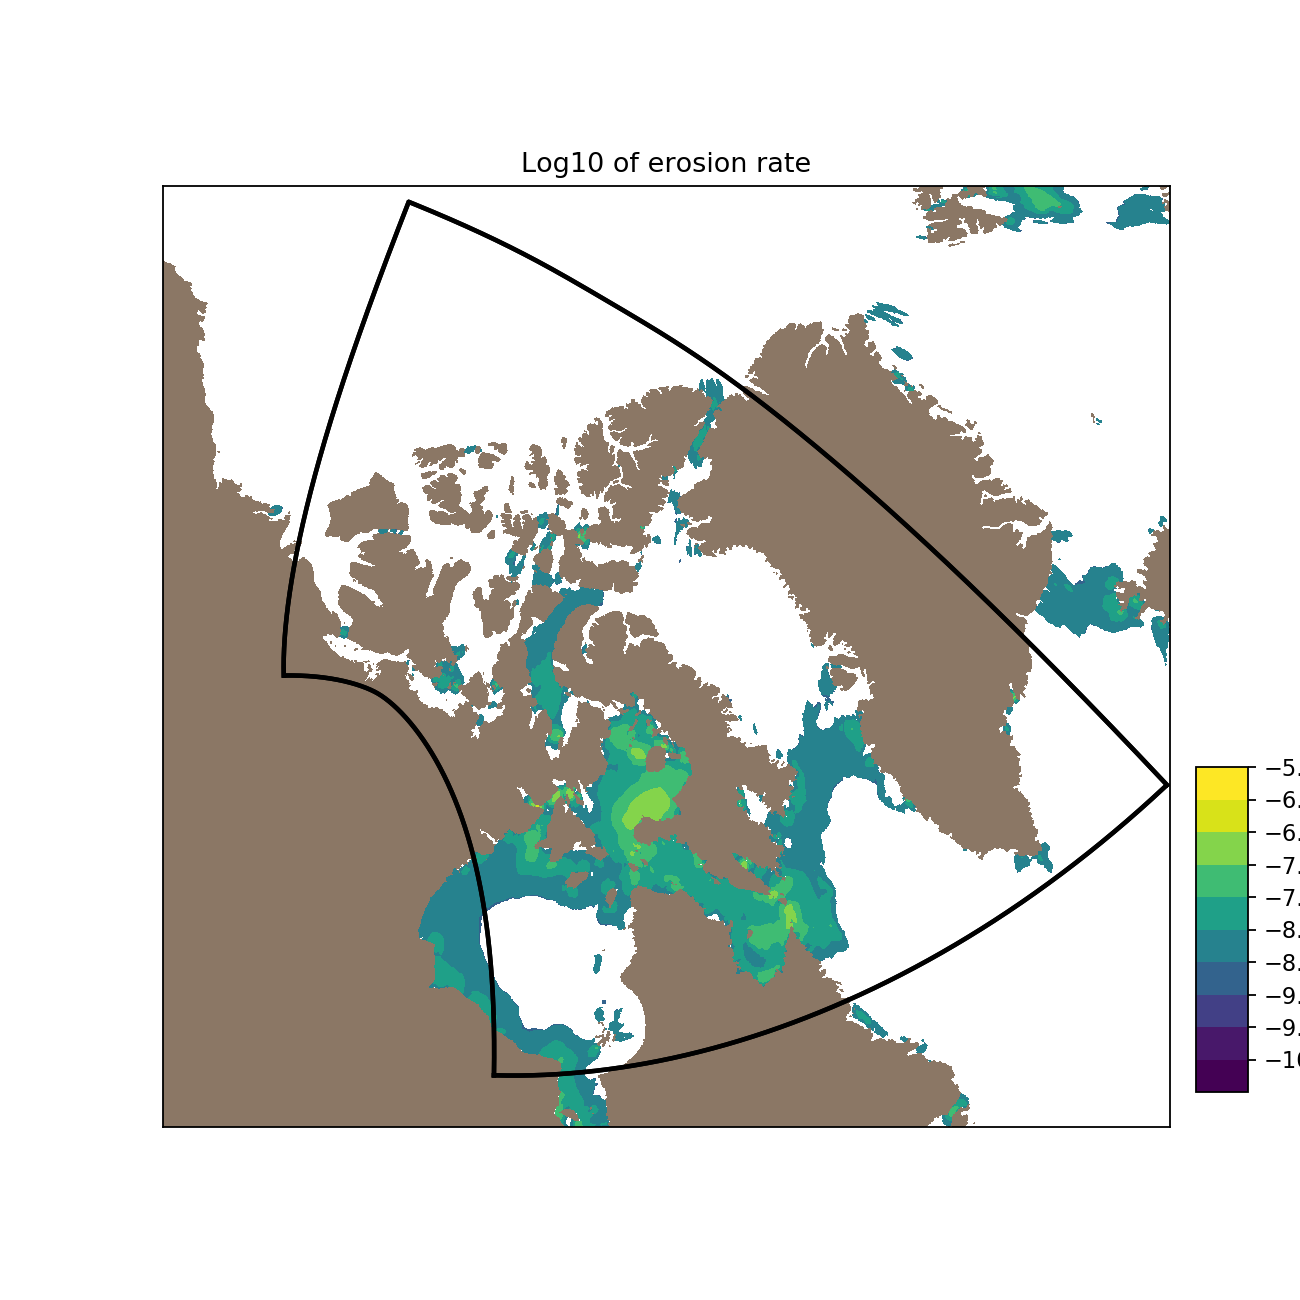

In [36]:
fig, ax1, proj1= pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/surface-Pb.pickle','rb'))
# Sub-domain map: ---------------------------------------------------------------------------
x_sub, y_sub  = proj1(mesh_lon, mesh_lat) 
proj1.plot(x_sub[imin:imax,jmax],   y_sub[imin:imax,jmax],   'k-', lw=2.0,zorder=5)
proj1.plot(x_sub[imin:imax,jmax].T, y_sub[imin:imax,jmax].T, 'k-', lw=2.0,zorder=5)
proj1.plot(x_sub[imin:imax,jmin],   y_sub[imin:imax,jmin],   'k-', lw=2.0,zorder=5)
proj1.plot(x_sub[imin:imax,jmin].T, y_sub[imin:imax,jmin].T, 'k-', lw=2.0,zorder=5)
proj1.plot(x_sub[imin,jmin:jmax],    y_sub[imin,jmin:jmax],    'k-', lw=2.0,zorder=5)
proj1.plot(x_sub[imin,jmin:jmax].T,  y_sub[imin,jmin:jmax].T,  'k-', lw=2.0,zorder=5)
proj1.plot(x_sub[imax,jmin:jmax],    y_sub[imax,jmin:jmax],    'k-', lw=2.0,zorder=5)
proj1.plot(x_sub[imax,jmin:jmax].T,  y_sub[imax,jmin:jmax].T,  'k-', lw=2.0,zorder=5)

# tidal stress:
CB = proj1.contourf(x_sub, y_sub, log_erosion_rate, vmin=-10, vmax=-6, \
                    levels=[-14, -10, -9.5, -9, -8.5, -8, -7.5, -7, -6.5, -6, -5])

ax1.set_title('Log10 of erosion rate')

cbaxes = fig.add_axes([0.92, 0.16, 0.04, 0.25])
CBar = plt.colorbar(CB, cax=cbaxes, ticks=[-10, -9.5, -9, -8.5, -8, -7.5, -7, -6.5, -6, -5])
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/sub-domain.png', bbox_inches='tight')

In [38]:
print('Units [g/m2/yr]')
print('Average erosion rate in domain: ', np.average(erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600)
print('Maximum erosion rate in domain: ', np.amax(erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600)
print('Minimum erosion rate in domain: ', np.amin(erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600)

Units [g/m2/yr]
Average erosion rate in domain:  72.61272475331266
Maximum erosion rate in domain:  12106.925455997029
Minimum erosion rate in domain:  0.0


# Write to NetCDF file

In [39]:
c   = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12-EXH006_y2015m01d05_gridT.nc','r')
lon = np.array(c.variables['nav_lon'])
lat = np.array(c.variables['nav_lat'])

In [40]:
ncd = nc.Dataset('/ocean/brogalla/GEOTRACES/data/erosion_rate-20200406.nc', 'w', zlib=True)
ncd.createDimension('x',len(c.dimensions['x']))
ncd.createDimension('y',len(c.dimensions['y']))

<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 2400

In [41]:
# variables
nav_lat = ncd.createVariable('nav_lat', 'float32', ('y','x'))
nav_lat.long_name = 'Latitude'
nav_lat.units = 'degrees_north'
nav_lat[:] = lat

nav_lon = ncd.createVariable('nav_lon', 'float32', ('y','x'))
nav_lon.long_name = 'Longitude'
nav_lon.units = 'degrees_east'
nav_lon[:] = lon

mn_resus = ncd.createVariable('er_rate', 'float32', ('y','x'))
mn_resus.units = 'NA'
mn_resus.long_name = 'Erosion rate'  
mn_resus.coordinates = 'nav_lon nav_lat'
mn_resus[:] = erosion_rate

In [42]:
ncd.close()

In [44]:
c = nc.Dataset('/ocean/brogalla/GEOTRACES/data/erosion_rate-20200406.nc','r')
print(np.amax(c.variables['er_rate']))
print(np.amin(c.variables['er_rate']))
print(np.average(c.variables['er_rate']))

3.9184164e-07
0.0
8.4629737e-10
